In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from import_file import *
load_libs()

# 0. Input Setup

In [2]:
# Only need x, y as data
input_file='./data/barebone_dat.csv'
df = pd.read_csv(input_file, header=0, skipinitialspace=True)

df

,x,y
0,2.29,-0.41
1,3.39,-2.80
2,4.13,-1.54
3,4.27,-2.97
4,3.30,-0.92
5,1.33,-2.03
6,1.64,-2.65
7,0.08,-4.95
8,0.30,-4.70
9,-1.31,-5.35


In [3]:
NUMBER_OF_GAUSSIAN = 3
BIN_WIDTH = 0.5   
KNOT_UNIT = False

In [4]:
## Set up automation
if 'FIT_METHOD' not in globals():
    FIT_METHOD = 'square_error'       
if 'KDE_KERNEL' not in globals():
    KDE_KERNEL = 'gaussian'

# 1. Fitting range setup automation

In [5]:
df['speed']=np.sqrt(df.x**2+df.y**2)
fit_limit = ceil(df['speed'].quantile(.95))
fitting_axis_range = arange(-fit_limit, fit_limit+BIN_WIDTH, BIN_WIDTH)
print(fitting_axis_range)

FITTING_RANGE = []
for i in fitting_axis_range:
    for j in fitting_axis_range:
        FITTING_RANGE.append([i,j])

[-10.   -9.5  -9.   -8.5  -8.   -7.5  -7.   -6.5  -6.   -5.5  -5.   -4.5
  -4.   -3.5  -3.   -2.5  -2.   -1.5  -1.   -0.5   0.    0.5   1.    1.5
   2.    2.5   3.    3.5   4.    4.5   5.    5.5   6.    6.5   7.    7.5
   8.    8.5   9.    9.5  10. ]


# 2. Bandwidth selection

0.8
Wall time: 22 s


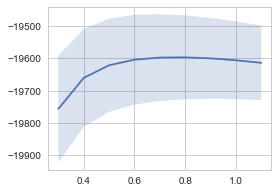

In [6]:
%%time
from sklearn.model_selection import GridSearchCV  

# The bandwidth value sometimes would be too radical
if KNOT_UNIT:
    bandwidth_range = arange(0.7,2,0.2)
else:
    bandwidth_range = arange(0.3,1.2,0.1)

# Grid search is unable to deal with too many data (a long time is needed)
if len(df) > 50000:    
    df_resample=df.sample(n=40000, replace=True)
    bandwidth_search_sample = array(list(zip(df_resample.x, df_resample.y)))
else:
    bandwidth_search_sample = array(list(zip(df.x, df.y)))

grid = GridSearchCV(neighbors.KernelDensity(kernel=KDE_KERNEL),
                {'bandwidth': bandwidth_range}, n_jobs=-1, cv=4, return_train_score=False) 

grid.fit(bandwidth_search_sample)
bandwidth = grid.best_params_['bandwidth']
plt.plot(bandwidth_range, grid.cv_results_['mean_test_score'], label='test')
plt.fill_between(bandwidth_range,
                 grid.cv_results_['mean_test_score']+grid.cv_results_['std_test_score'], 
                 grid.cv_results_['mean_test_score']-grid.cv_results_['std_test_score'], alpha=0.2)
plt_configure(figsize=(4,3))
    
print(bandwidth)

# 3. Fit and result

In [7]:
config = {'bandwidth': bandwidth, 
          'fitting_range': FITTING_RANGE,
          'fit_limit': fit_limit,
          'kde_kernel': KDE_KERNEL,
          'bin_width': BIN_WIDTH}

print(bandwidth, FIT_METHOD)

0.8 square_error


In [8]:
result = fit_gmm(df, fit_method=FIT_METHOD, number_of_gaussian=NUMBER_OF_GAUSSIAN,
                 config=config)

In [9]:
result

{'gmm': [array([ 0.69822635, -1.81673003,  2.04940502,  3.25785795,  3.38627552,
         -0.02301951]),
  array([ 0.25395674,  1.02189151, -3.89103267,  2.44980076,  2.73949571,
          0.29900356]),
  array([ 0.04781691, -1.8850461 , -1.20087784,  1.06943136,  1.77274881,
         -0.49753205])],
 'gmm_pdf_result': array([  7.84918505e-07,   1.23952519e-06,   1.94581337e-06, ...,
          1.43525739e-06,   1.03401901e-06,   7.29206720e-07]),
 'kde_clf': KernelDensity(algorithm='auto', atol=0, bandwidth=0.80000000000000027,
        breadth_first=True, kernel='gaussian', leaf_size=40,
        metric='euclidean', metric_params=None, rtol=0),
 'kde_result': array([  3.31092800e-06,   6.71224318e-06,   1.35012938e-05, ...,
          1.73724866e-07,   5.78042792e-08,   1.49732175e-08]),
 'number_of_iteration': 105}

In [10]:
pretty_print_gmm(result['gmm'])

,weight,mean_x,mean_y,sig_x,sig_y,corr
1,0.698,-1.817,2.049,3.258,3.386,-0.023
2,0.254,1.022,-3.891,2.450,2.739,0.299
3,0.048,-1.885,-1.201,1.069,1.773,-0.498
